In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
# KODEX 레버리지 1년치 분봉 데이터
leverage_df = pd.read_csv('../122630.csv', index_col=0).iloc[::-1]
leverage_df.index = pd.to_datetime([x // 100 for x in leverage_df.index], format='%Y%m%d%H%M')
# KODEX 선물인버스X2 1년치 분봉 데이터
inverse2x_df = pd.read_csv('../252670.csv', index_col=0).iloc[::-1]
inverse2x_df.index = pd.to_datetime([x // 100 for x in inverse2x_df.index], format='%Y%m%d%H%M')

In [3]:
inverse2x_df.head()

,open,high,low,close,volume
2019-12-02 09:00:00,7025,7040,7020,7035,870090
2019-12-02 09:01:00,7030,7035,7010,7015,192497
2019-12-02 09:02:00,7015,7025,7010,7020,228011
2019-12-02 09:03:00,7025,7035,7015,7035,227674
2019-12-02 09:04:00,7035,7035,7010,7020,566828


In [4]:
inverse2x_df.shape

(97547, 5)

In [5]:
num_ticks=[3, 5, 10, 15]

In [6]:
def add_moving_stats(df, num_ticks):
    _df = df.copy()
    for num in num_ticks:
        _df['close_mv_avg_{}'.format(num)] = df['close'].rolling(num).mean()
#         _df['close_mv_std_{}'.format(num)] = df['close'].rolling(num).std()
    return _df

In [7]:
df = add_moving_stats(inverse2x_df, num_ticks)

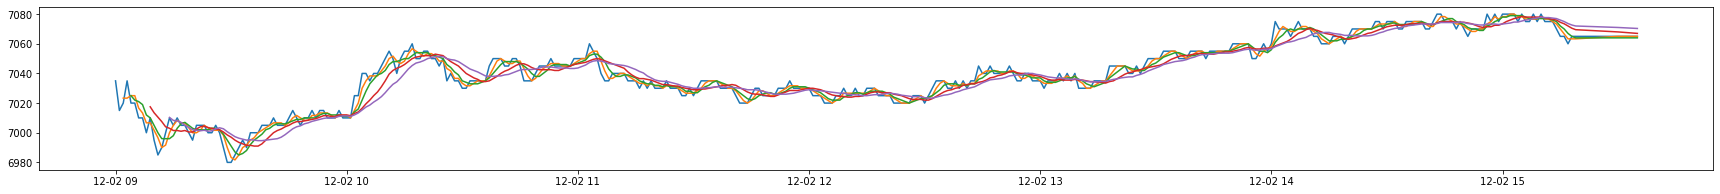

In [8]:
plt.figure(figsize=(30,3))
plt.plot(df['2019-12-02']['close'])
for num in num_ticks:
    plt.plot(df['2019-12-02']['close_mv_avg_{}'.format(num)])

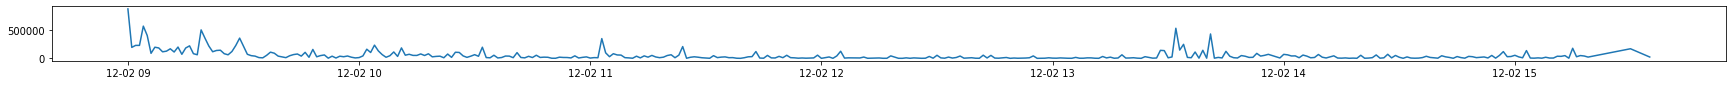

In [9]:
plt.figure(figsize=(30,1))
plt.plot(df['2019-12-02']['volume'])

In [10]:
def is_increasing(col, window=5):
    tmp = list(col)
    is_inc = []
    for i in range(len(tmp)):
        if i < window:
            is_inc.append(False)
        else:
            if tmp[i] > tmp[i-window]:
                is_inc.append(True)
            else:
                is_inc.append(False)
    return is_inc

In [11]:
def is_decreasing(col, window=5):
    tmp = list(col)
    is_dec = []
    for i in range(len(tmp)):
        if i < window:
            is_dec.append(False)
        else:
            if tmp[i] < tmp[i-window]:
                is_dec.append(True)
            else:
                is_dec.append(False)
    return is_dec

In [12]:
def is_overtake(col1, col2):
    # arg1의 관점에서, arg2를 추월했는지 여부
    
    tmp1, tmp2 = list(col1), list(col2)

    is_otk = [False]

    for i in range(1, len(tmp1)):
        
        if tmp1[i] > tmp2[i] and tmp1[i-1] < tmp2[i-1]:
            is_otk.append(True)
        else:
            is_otk.append(False)

    return is_otk

In [13]:
# Add Features
for x,y in combinations(num_ticks, 2):
    df['is_{}_otk_{}'.format(x,y)] = is_overtake(df['close_mv_avg_{}'.format(x)], df['close_mv_avg_{}'.format(y)])
for x,y in combinations(num_ticks[::-1], 2):
    df['is_{}_otk_{}'.format(x,y)] = is_overtake(df['close_mv_avg_{}'.format(x)], df['close_mv_avg_{}'.format(y)])
for num in num_ticks:
    df['is_inc_mv_avg_{}'.format(num)] = is_increasing(df['close_mv_avg_{}'.format(num)])
for num in num_ticks:
    df['is_dec_mv_avg_{}'.format(num)] = is_decreasing(df['close_mv_avg_{}'.format(num)])

In [14]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'close_mv_avg_3',
       'close_mv_avg_5', 'close_mv_avg_10', 'close_mv_avg_15', 'is_3_otk_5',
       'is_3_otk_10', 'is_3_otk_15', 'is_5_otk_10', 'is_5_otk_15',
       'is_10_otk_15', 'is_15_otk_10', 'is_15_otk_5', 'is_15_otk_3',
       'is_10_otk_5', 'is_10_otk_3', 'is_5_otk_3', 'is_inc_mv_avg_3',
       'is_inc_mv_avg_5', 'is_inc_mv_avg_10', 'is_inc_mv_avg_15',
       'is_dec_mv_avg_3', 'is_dec_mv_avg_5', 'is_dec_mv_avg_10',
       'is_dec_mv_avg_15'],
      dtype='object')

In [15]:
def idx_to_datetime_str(date, idx):
    idx = idx - (idx // 390) * 390
    hour = 9 + (idx // 60)
    minute = idx - (idx // 60) * 60
    hour_str = str(hour)
    minute_str = str(minute)
    if len(hour_str) < 2:
        hour_str = '0' + hour_str
    if len(minute_str) < 2:
        minute_str = '0' + minute_str
    return '{} {}:{}:00'.format(date, hour_str, minute_str)

In [16]:
def get_profit_ratio(df, buy_conds, sell_conds, viz=False):

    _df = df.reset_index()
    
    ############# 매수 / 매도 조건 #############
    buy_cond = _df[buy_conds[0]]
    if len(buy_conds) > 1:
        for cond in buy_conds[1:]:
            buy_cond &= _df[cond]

    sell_cond = _df[sell_conds[0]]
    if len(sell_conds) > 1:
        for cond in sell_conds[1:]:
            sell_cond &= _df[cond]      

    ############# 매수 / 매도 시점 후보 #############
    buy_point_cand = _df[buy_cond].index
    sell_point_cand = _df[sell_cond].index

    ############# 매수 / 매도 시점 선택 #############
    buy_point = []
    sell_point = []

    for bp in buy_point_cand:

        if len(buy_point) == len(sell_point):
            if not buy_point or (bp > sell_point[-1]):
                buy_point.append(bp)

        if len(buy_point) > len(sell_point):
            for sp in sell_point_cand:
                if sp > buy_point[-1]:
                    if not sell_point or (sp > buy_point[-1]):
                        sell_point.append(sp)
                        break

    # 팔 기회가 없었던 경우, 당일 동시호가 시간 직전 종가로 청산
    if len(buy_point) > len(sell_point):
        sell_point.append(len(_df) - 11)
    
    ############# 매수 / 매도 시점 시각화 #############
    if viz:        
        plt.figure(figsize=(30,3))
        for col in _df.columns:
            if 'close' in col:
                plt.plot(_df[col])
        for i in buy_point:
            plt.axvline(i, c='r')
        for i in sell_point:
            plt.axvline(i, c='b')
        # 거래량
        plt.figure(figsize=(30,1))
        plt.plot(_df['volume'])

    ############# 기하 수익률 계산 #############
    # 거래 없음
    if not buy_point:
        profit_ratio = 0

    else:
        profit_ratios = []
        for bp, sp in zip(buy_point, sell_point):
            buy_price = _df.iloc[bp]['close']
            sell_price = _df.iloc[sp]['close']
            profit_ratios.append((sell_price - buy_price) / buy_price)
        profit_ratio = np.power(np.prod([(x+1) for x in profit_ratios]), 
                                1/len(profit_ratios)) - 1
    return profit_ratio

CPU times: user 90.5 ms, sys: 10.3 ms, total: 101 ms
Wall time: 159 ms


-0.00035925769799538543

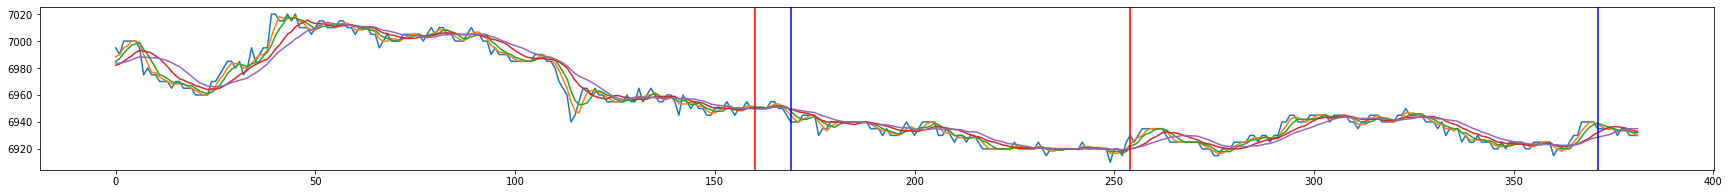

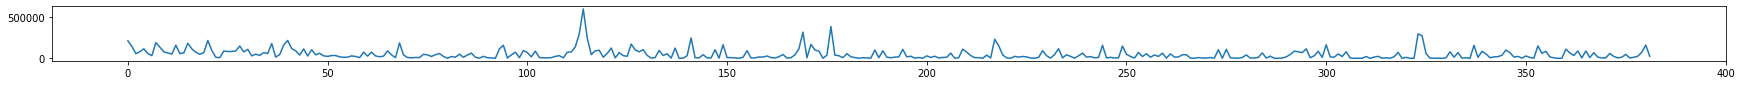

In [17]:
%time get_profit_ratio(df['2019-12-11'],\
                       buy_conds=['is_5_otk_10', 'is_inc_mv_avg_5', 'is_inc_mv_avg_10'],\
                       sell_conds=['is_10_otk_5', 'is_dec_mv_avg_10', 'is_dec_mv_avg_10'],\
                       viz=True)

In [18]:
dates = [x.strftime('%Y-%m-%d') for x in pd.date_range(df.index[0], df.index[-1])]

In [19]:
def get_profit_ratio_for_range(df, dates, buy_conds, sell_conds):
    profit_ratios = []
    for date in dates:
        if date in df.index:
            pr = get_profit_ratio(df[date], buy_conds, sell_conds, viz=False)
            profit_ratios.append(pr)
    profit_ratio = np.power(np.prod([(x+1) for x in profit_ratios]), 1/len(profit_ratios)) - 1
    return profit_ratio

In [20]:
buy_conds=['is_5_otk_10', 'is_inc_mv_avg_5', 'is_inc_mv_avg_10']
sell_conds=['is_10_otk_5', 'is_dec_mv_avg_5', 'is_dec_mv_avg_10']

%time get_profit_ratio_for_range(df, dates, buy_conds, sell_conds)

CPU times: user 4.44 s, sys: 82.7 ms, total: 4.52 s
Wall time: 5.52 s


-0.000607405654882931

In [21]:
buy_conds=['is_3_otk_5', 'is_inc_mv_avg_3', 'is_inc_mv_avg_5', 'is_inc_mv_avg_10']
sell_conds=['is_5_otk_3', 'is_dec_mv_avg_3', 'is_dec_mv_avg_5', 'is_dec_mv_avg_10']

%time get_profit_ratio_for_range(df, dates, buy_conds, sell_conds)

CPU times: user 4.37 s, sys: 46.6 ms, total: 4.42 s
Wall time: 4.66 s


0.00020541482695590751

In [22]:
_buy_cond_cands = ['is_3_otk_5', 'is_3_otk_10', 'is_3_otk_15', 
                  'is_5_otk_10', 'is_5_otk_15', 'is_10_otk_15', 
                  'is_inc_mv_avg_3', 'is_inc_mv_avg_5', 'is_inc_mv_avg_10', 'is_inc_mv_avg_15']

_sell_cond_cands = ['is_15_otk_10', 'is_15_otk_5', 'is_15_otk_3',
                  'is_10_otk_5', 'is_10_otk_3', 'is_5_otk_3', 
                  'is_dec_mv_avg_3', 'is_dec_mv_avg_5', 'is_dec_mv_avg_10','is_dec_mv_avg_15']

In [23]:
buy_cond_cands = []
for i in range(1, len(_buy_cond_cands) // 3):
    for x in combinations(_buy_cond_cands, i):
        buy_cond_cands.append(x)
        
sell_cond_cands = []
for i in range(1, len(_sell_cond_cands) // 3):
    for x in combinations(_sell_cond_cands, i):
        sell_cond_cands.append(x)

In [24]:
strategy_cands = [(x,y) for x,y in product(buy_cond_cands, sell_cond_cands)]

In [25]:
len(strategy_cands)

3025

In [26]:
strategy_cands[0:10]

[(('is_3_otk_5',), ('is_15_otk_10',)),
 (('is_3_otk_5',), ('is_15_otk_5',)),
 (('is_3_otk_5',), ('is_15_otk_3',)),
 (('is_3_otk_5',), ('is_10_otk_5',)),
 (('is_3_otk_5',), ('is_10_otk_3',)),
 (('is_3_otk_5',), ('is_5_otk_3',)),
 (('is_3_otk_5',), ('is_dec_mv_avg_3',)),
 (('is_3_otk_5',), ('is_dec_mv_avg_5',)),
 (('is_3_otk_5',), ('is_dec_mv_avg_10',)),
 (('is_3_otk_5',), ('is_dec_mv_avg_15',))]

### TODO: 평가 함수 속도 최적화 필요. 탐색도 너무 비효율적임. 유전 알고리즘과 같은 메타 휴리스틱 서치 필요할듯

In [27]:
# from tqdm import tqdm
# profit_by_strategy = dict()
# for strategy_cand in tqdm(strategy_cands):
#     buy_conds, sell_conds = strategy_cand
#     profit_ratio = get_profit_ratio_for_range(df, dates, buy_conds, sell_conds)
#     print(strategy_cand, profit_ratio)
#     profit_by_strategy[strategy_cand] = profit_ratio